논문 제시 Architecture

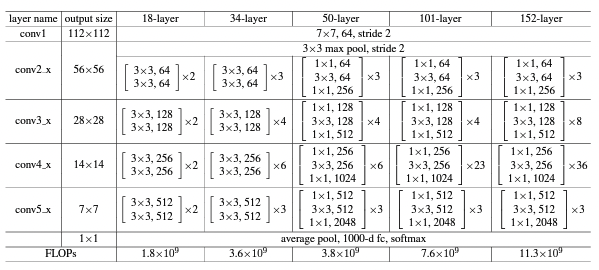

Introduction

* feature의 level은 stacked layer의 깊이로 풍부해졌다.
* 최근 네트워크 깊이의 중요성을 다룬 연구들이 있고, imageNet에서 성능이 좋은 구조도 16-30층의 깊은 네트워크이다.
* layer를 깊이 쌓을수록 더 쉽게 학습할까?

여기서 두가지 장애물이 있다.
1. Convergence Problem
2. Degradation Problem

### 1. Convergence Problem
* vanishing/exploding gradients 으로 발생한다.
* 학습 초기부터 convergence를 방해한다.

### 2. Degradation Problem
* Convergence가 가능해지고 나니 degradation문제가 발생한다.
* network 깊이가 증가할수록 accuracy가 포화되고, 그 이후로 빠르게 하락한다.
* overfitting 문제는 아니고, layer를 추가할수록 training error가 높아진다.



Resnet 주요 개념

1. Residual Learning(잔차 학습)

Resnet은 깊은 신경망에서 발생할 수 있는 vanishing gradient문제를 residual learning으로 해결한다. 잔차학습은 네트워크의 스킵 연결을 통해 입력과 출력 사이의 residual을 직접 학습하는 방식이다.

깊은 신경망을 훈련시키는 동안 gradient가 하위 층으로 전파될 때 그래디언트 값이 점차 작아지는 문제가 발생할 수 있다. 이는 학습이 제대로 수행되지 않거나 수렴 속도가 느려지는 문제가 발생한다. 잔차학습은 이러한 문제를 해결하기 위해 네트워크에 스킵 연결을 추가함으로서 잔차를 직접 학습할 수 있도록 한다.

Resnet의 핵심 아이디어는 기존의 층이 학습한 결과에 입력 데이터를 더하는 것이다. 이를 수식으로 나타내면 다음과 같다.

```
y = F(x) + x
```

잔차 학습은 vanishing gradient문제를 완화하여 깊은 신경망에서도 효과적인 학습을 가능하게 한다. 두번째, 스킵 연결은 정보의 손실 없이 입력과 출력 사이의 경로를 보존하므로, 모델이 더 쉽게 최적화되고, 더 빠르게 수렴할 수 있다. 또한 깊에 쌓을 수 있도록하여, 더 복잡하고 표현력이 강력한 모델을 구축할 수 있다.

2. Shortcut의 두가지 Equation

Resnet은 입력과 출력의 사이즈에 따라서 두가지 shortcut 방정식을 제안한다.

  * x 와 F()의 차원이 같을 때
y = F(x, {Wi}) + x.
  * x 와 F()의 차원이 다를 때
y = F(x, {Wi}) + Wsx.

In [ ]:
# 구현

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class BasicBlock(layers.Layer):
  mul = 1
  def __init__(self, in_planes, out_planes, stride=1):
    super(BasicBlock, self).__init__()

    self.conv1 = layers.Conv2D(out_planes, kernel_size=3, strides=stride, padding='same', use_bias=False)
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(out_planes, kernel_size=3, strides=1, padding='same', use_bias=False)
    self.bn2 = layers.BatchNormalization()

    self.shortcut = tf.identity

    if stride != 1:
      self.shortcut = layers.Conv2D(out_planes, kernel_size=1, strides=stride, use_bias=False)

  def call(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = tf.nn.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x)
    out = tf.nn.relu(out)
    return out

class BottleNeck(layers.Layer):
  mul = 4

  def __init__(self, in_planes, out_planes, stride=1):
    super(BottleNeck, self).__init__()

    self.conv1 = layers.Conv2D(out_planes, kernel_size=1, strides=stride, use_bias=False)
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(out_planes, kernel_size=3, strides=1, padding='same', use_bias=False)
    self.bn2 = layers.BatchNormalization()

    self.conv3 = layers.Conv2D(out_planes * self.mul, kernel_size=1, strides=1, use_bias=False)
    self.bn3 = layers.BatchNormalization()

    self.shortcut = tf.identity

    if stride != 1 or in_planes != out_planes * self.mul:
      self.shortcut = layers.Conv2D(out_planes * self.mul, kernel_size=1, strides=stride, use_bias=False)

  def call(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = tf.nn.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = tf.nn.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)
    out += self.shortcut(x)
    out = tf.nn.relu(out)
    return out


class ResNet(tf.keras.Model):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()

    self.in_planes = 64

    self.conv1 = layers.Conv2D(self.in_planes, kernel_size=7, strides=2, padding='same')
    self.bn1 = layers.BatchNormalization()
    self.maxpool1 = layers.MaxPool2D(pool_size=3, strides=2, padding='same')

    self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
    self.avgpool = layers.GlobalAveragePooling2D()
    self.linear = layers.Dense(num_classes)

  def make_layer(self, block, out_planes, num_blocks, stride):

    strides = [stride] + [1] * (num_blocks - 1)
    layers_list = []
    for stride in strides:
      layers_list.append(block(self.in_planes, out_planes, stride))
      self.in_planes = block.mul * out_planes

    return tf.keras.Sequential(layers_list)


  def call(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = tf.nn.relu(out)
    out = self.maxpool1(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.avgpool(out)
    out = tf.keras.layers.Flatten()(out)
    out = self.linear(out)
    return out

  def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])
  def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])
  def ResNet50():
    return ResNet(BottleNeck, [3,4,6,3])
  def ResNet101():
    return ResNet(BottleNeck, [3,4,23,3])
  def ResNet152():
    return ResNet(BottleNeck, [3,8,36,3])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [ ]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf

model = ResNet.ResNet50()
learning_rate = 0.1

model.compile(
    optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, weight_decay=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

model.fit(
    ds_train,
    epochs=150,
    validation_data=ds_test,
    callbacks=[es],
)


Epoch 1/150
391/391 [==============================] - 59s 68ms/step - loss: 9.6651 - accuracy: 0.1001 - val_loss: 9.6685 - val_accuracy: 0.1000
Epoch 2/150
391/391 [==============================] - 22s 57ms/step - loss: 9.6685 - accuracy: 0.1000 - val_loss: 9.6685 - val_accuracy: 0.1000
Epoch 3/150
391/391 [==============================] - 23s 58ms/step - loss: 9.6685 - accuracy: 0.1000 - val_loss: 9.6685 - val_accuracy: 0.1000
Epoch 4/150
391/391 [==============================] - 22s 57ms/step - loss: 9.6685 - accuracy: 0.1000 - val_loss: 9.6685 - val_accuracy: 0.1000
Epoch 5/150
391/391 [==============================] - 23s 58ms/step - loss: 9.6685 - accuracy: 0.1000 - val_loss: 9.6685 - val_accuracy: 0.1000
Epoch 6/150
391/391 [==============================] - 23s 57ms/step - loss: 9.6685 - accuracy: 0.1000 - val_loss: 9.6685 - val_accuracy: 0.1000
Epoch 7/150
391/391 [==============================] - 23s 58ms/step - loss: 9.6685 - accuracy: 0.1000 - val_loss: 9.6685 - val_ac

KeyboardInterrupt: ignored